TypeError: Expected a Runnable, callable or dict.Instead got an unsupported type: <class 'str'>

In [2]:
import os
from langchain_openai import ChatOpenAI
from srt_prompt import build_prompt_srt
from srt_schema import  SrtLLMResponse
def get_srt_chain():

    llm = ChatOpenAI(
        model="llama3.1-8b",
        api_key=os.getenv("CEREBRAS_LECTURETTE_KEY"),
        base_url="https://api.cerebras.ai/v1",
        temperature=0.2,
    )

    prompt = build_prompt_srt()

    return prompt | llm.with_structured_output(SrtLLMResponse)

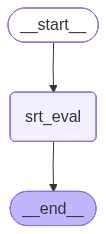

In [7]:
import asyncio
import json
from typing import List

from langgraph.graph import StateGraph, END

from srt_schema import SrtItemInput, SrtItemOutput

from srt_schema import SrtLLMResponse
def chain():
    return "good"

chain = chain()
sem = asyncio.Semaphore(10)


async def evaluate_one(item: SrtItemInput) -> SrtItemOutput:
    async with sem:

        res: SrtLLMResponse = await chain.ainvoke({
            "sit": item.situation,
            "react": item.reaction
        })

        return SrtItemOutput(
            situationNo=item.situationNo,
            situation=item.situation,
            reaction=item.reaction,
            grade=res.grade,
            feedback=res.feedback,
            improvement=res.improvement
        )

async def run_parallel(items: List[SrtItemInput]):

    tasks = [evaluate_one(i) for i in items]
    results: List[SrtItemOutput] = await asyncio.gather(*tasks)

    score_map = {
        "BAD": 1,
        "AVERAGE": 2,
        "GOOD": 3,
        "EXCELLENT": 4
    }

    avg = sum(score_map[r.grade] for r in results) / len(results)

    if avg < 1.8:
        overall = "BAD"
    elif avg < 2.5:
        overall = "AVERAGE"
    elif avg < 3.3:
        overall = "GOOD"
    else:
        overall = "EXCELLENT"

    return {
        "overall": overall,
        "items": results
    }


def build_graph():
    graph = StateGraph(dict)

    async def node(state):
        items = state["items"]
        result = await run_parallel(items)
        return {"result": result}

    graph.add_node("srt_eval", node)
    graph.set_entry_point("srt_eval")
    graph.add_edge("srt_eval", END)

    return graph.compile()
build_graph()

In [ ]:
srt